In [1]:
from __future__ import print_function

import os
import sys
sys.path.append('/home/jogi/git/repository/smart_play_set')

import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

from utils.smart_utils import FuturoCube, calc_cos_sim, get_other_label
from preprocessing.process_data import get_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def create_level_sets(X, skill_labels, id_labels, level_labels):
    
    unique_levels = np.unique(level_labels)
    print("INFO -- create_level_sets ", unique_levels)
    datasets = {}
    for l in unique_levels:
        rows = np.where(level_labels==l)[0]
        x_data = X[rows]
        y_data = skill_labels[rows]
        y_ids = id_labels[rows]
        y_levels = level_labels[rows]
        datasets[l] = (x_data, y_data, y_ids, y_levels)
    
    return datasets
    
def get_features(mask, features):

    for i, f in enumerate(mask):
        print("%d. %s" % (i+1, features[f]))

        
def transform_x(X, features_idx):
    
    X_new = np.zeros((X.shape[0], len(features_idx)))
    for i, idx in enumerate(features_idx):
        X_new[:, i] = X[:, idx]
        
    return X_new


def prepare_data(option=330, two_class_opt='2_and_1'):
    
    if option == 330:   # 30 seconds window
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_330_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    elif option == 275:
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_275_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)

    elif option == 990: # 10 seconds window
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_990_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    elif option == 1980:  # 5 seconds window
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_1980_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
        
    elif option == 3960:  # 5 seconds with 0.5 overlapping
        
        x_train_all, y_labels_all, y_other_labels, dta_dict_f = get_data('20161206', force=False, 
                                                               apply_window_func=True, calc_mag=True,
                                                               extra_label="20hz_1axis_low8hz_3960_12_True", 
                                                               optimal_w_size=False,
                                                               f_type='low', lowcut=8, b_order=5)
    else:
        raise NotImplementedError("Error, %s as option is not implemented" % str(option))

    features = dta_dict_f['features']

    y_labels_all = np.squeeze(y_labels_all)
    y_labels_2c = np.zeros(y_labels_all.shape[0], dtype=np.int)
    y_labels_2c[:] = y_labels_all[:]
    if two_class_opt == 'merge_1_2':
        # merge group 1 and 2
        y_labels_2c[y_labels_2c==2] = 1
        print(np.where(y_labels_2c==0)[0].shape)
        print(np.where(y_labels_2c==1)[0].shape)
    elif two_class_opt == 'merge_0_1':
        # merge 1 with 0 group
        y_labels_2c[y_labels_2c==1] = 0
        y_labels_2c[y_labels_2c==2] = 1
        print(np.where(y_labels_2c==0)[0].shape)
        print(np.where(y_labels_2c==1)[0].shape)
    elif two_class_opt == 'only_0_2':
        x_train_all = x_train_all[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_labels_all = y_labels_all[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_other_labels = y_other_labels[np.where((y_labels_all==0) | (y_labels_all==2))]
        y_labels_all[y_labels_all==2] = 1
        y_labels_2c = y_labels_all
    elif two_class_opt == 'only_0_1':
        x_train_all = x_train_all[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_labels_all = y_labels_all[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_other_labels = y_other_labels[np.where((y_labels_all==0) | (y_labels_all==1))]
        y_labels_2c = y_labels_all
        
    print("Unique labels y_labels_all ", np.unique(y_labels_all))
    print("Unique labels y_labels_2c ", np.unique(y_labels_2c))
    print("Class counts y_labels_all ", np.bincount(y_labels_all))
    print("Class counts y_labels_2c ", np.bincount(y_labels_2c))
    print("Shape x_train_all ", x_train_all.shape)
    print("Shape y_labels_all ", y_labels_all.shape)
    
    return x_train_all, y_labels_all, y_labels_2c, y_other_labels, features

x_train_all, y_labels_all, y_labels_2c, y_other_labels, features = prepare_data(330, two_class_opt='merge_1_2')
y_label_id = get_other_label(y_other_labels, "ID")
y_label_perm = get_other_label(y_other_labels, "perm")
y_label_level = get_other_label(y_other_labels, "level")

level_datasets_2c = create_level_sets(x_train_all, y_labels_2c, y_label_id, y_label_level)
level_datasets = create_level_sets(x_train_all, y_labels_all, y_label_id, y_label_level)

mabc_scores = {'6': 25., '35': 37., '13': 50., '38': 84., '37': 0.5, '2': 25., '11' : 5., '7': 84., '36': 63.,
'5': 50., '1': 50., '8': 1., '15': 1., '33': 84., '3': 16., '18': 84., '21': 16., '34': 63., '12': 50., '10': 75.,
'9': 37., '16': 16., '17': 16., '22': 9., '4': 25., '14': 84., '20': 25., '19': 1., '41': 5., '51': 16.}

feature_long_list = {0: "Minimum MI", 1: "RMS", 2: "Mean squared jerk", 3: "DC", 4: "Spectral energy",
                     5: "Power spectral entropy", 6: "Cosine similarity", 7: "Maximum MI",
                     8: "Mean MI", 9: "Stddev MI", 10: "Median MI", 11: "Range MI"}

INFO - Used data label 20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True
INFO Loading matrices from h5 file /mnt/disk2/git/repository/smart_play_set/data/futurocube/roadrunner/20161206_futurocube_roadrunner_20hz_1axis_low8hz_330_12_True.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data', u'label_game_level'])
INFO - Loading data description from json.
(210,)
(120,)
Unique labels y_labels_all  [0 1 2]
Unique labels y_labels_2c  [0 1]
Class counts y_labels_all  [210  60  60]
Class counts y_labels_2c  [210 120]
Shape x_train_all  (330, 12)
Shape y_labels_all  (330,)
INFO -- create_level_sets  [1 2 3]
INFO -- create_level_sets  [1 2 3]


In [4]:
def mabc_from_ids(ids, mabc_dict):
    
    y_mabc = np.zeros(len(ids))
    for r in np.arange(len(ids)):
        y_mabc[r] = mabc_dict[str(ids[r])]
    
    return y_mabc


def plot_mabc_feature_2D(x_data, y_data, scores, col_id, p_title, outfile=None):
    global features, feature_long_list
    
    plt.figure(figsize=(10,6))
    plt.title(p_title, fontsize=16)
    x_values = x_data[:, col_id]
    x_min = np.min(x_values)
    x_max = np.max(x_values)
    x_norm = (x_values - x_min) / float(x_max - x_min)

    y_0 = x_norm[np.where(y_data==0)]
    y_1 = x_norm[np.where(y_data==1)]
    x_0 = scores[np.where(y_data==0)]
    x_1 = scores[np.where(y_data==1)]
    plt.ylabel("Normalized %s value" % feature_long_list[col_id], fontsize=16)
    plt.xlabel("MABC-2 percentile", fontsize=16)
    
    
    plt.scatter(x_0, y_0, marker='H', c='g', label="%s" % "normal")
    plt.scatter(x_1, y_1, marker='D', c='r', label="delayed")

    plt.legend(loc="best")
    if outfile is not None:
        print("Save to %s" % outfile)
        plt.savefig(outfile, dpi=100)
    plt.show()

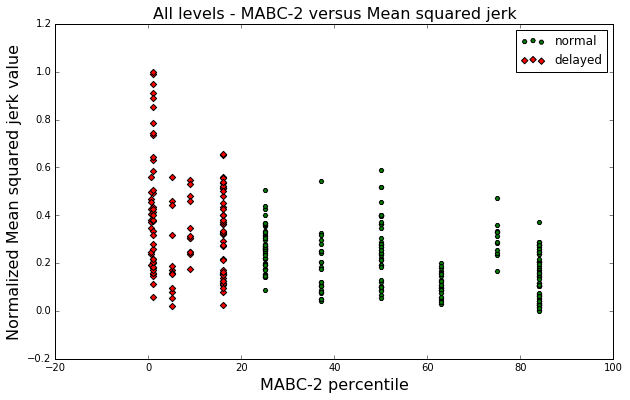

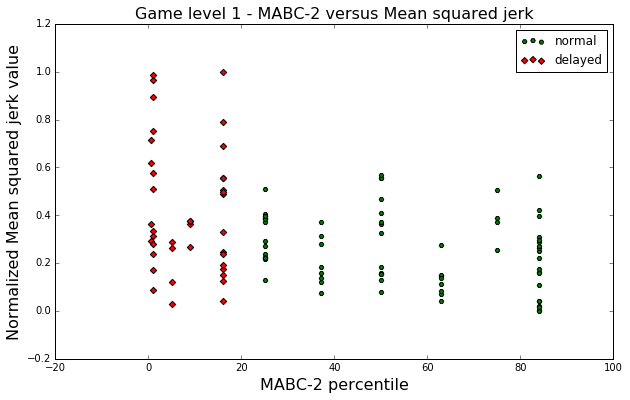

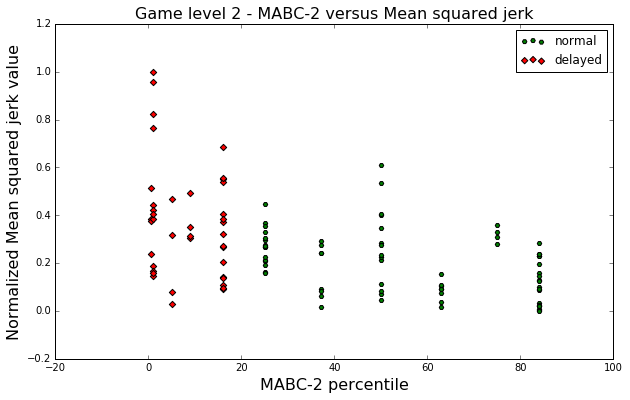

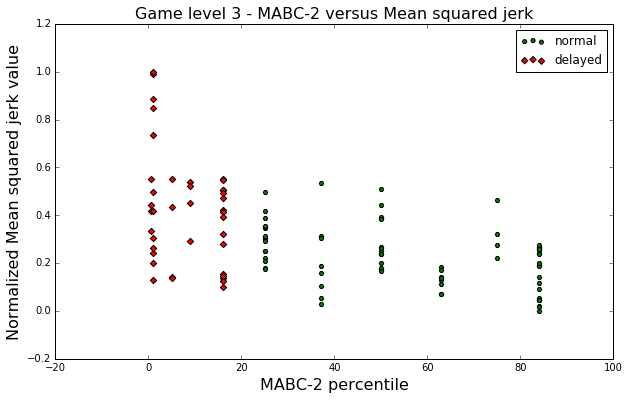

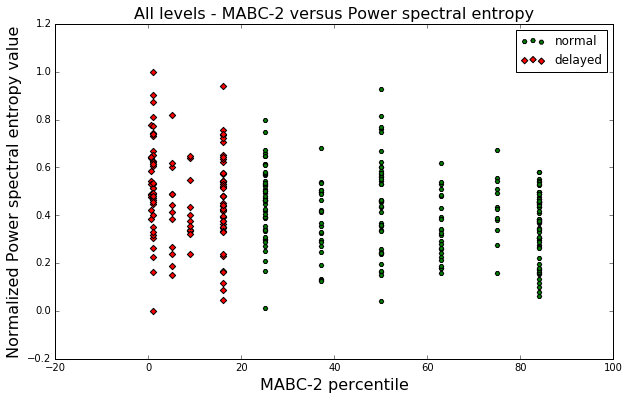

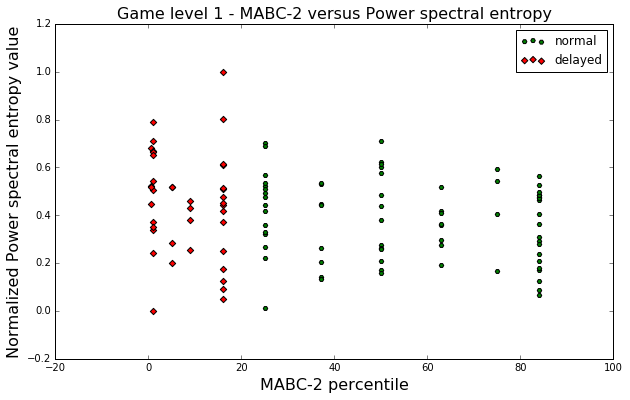

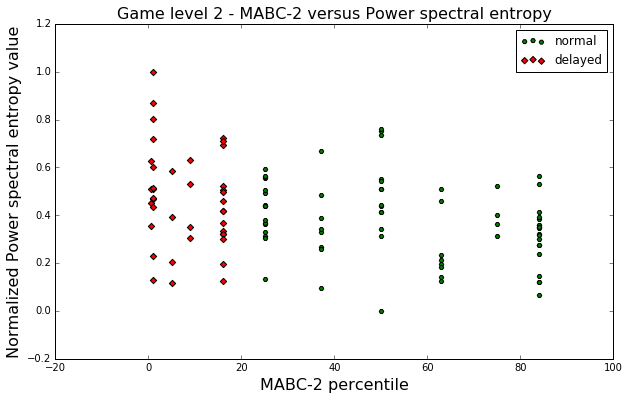

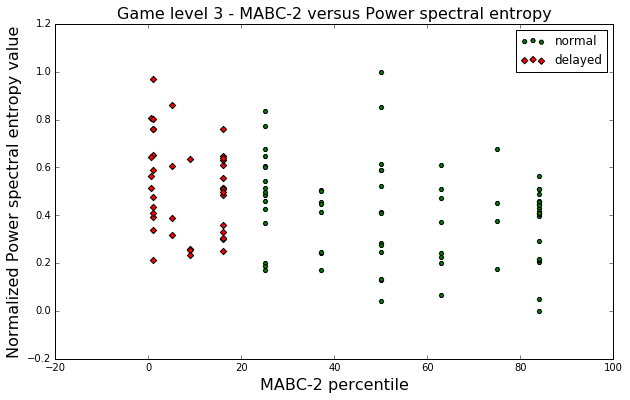

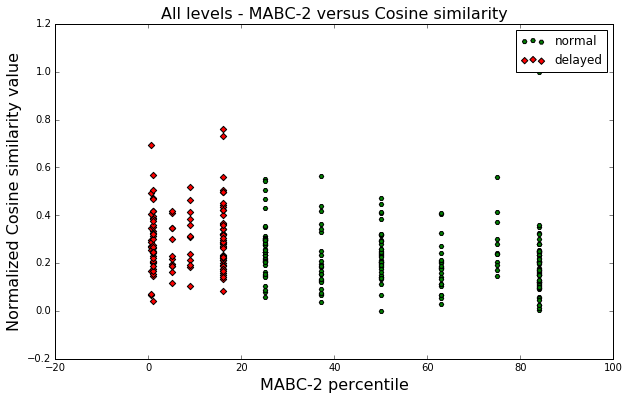

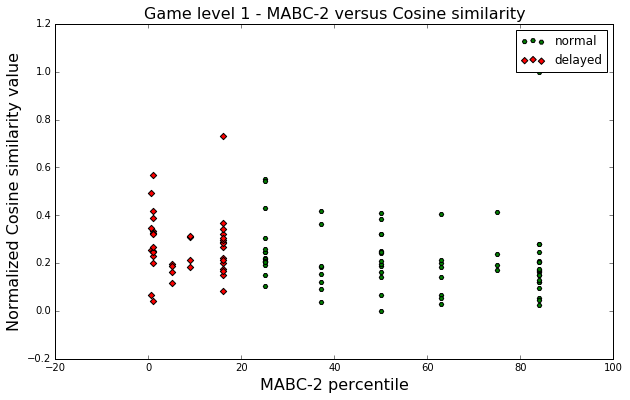

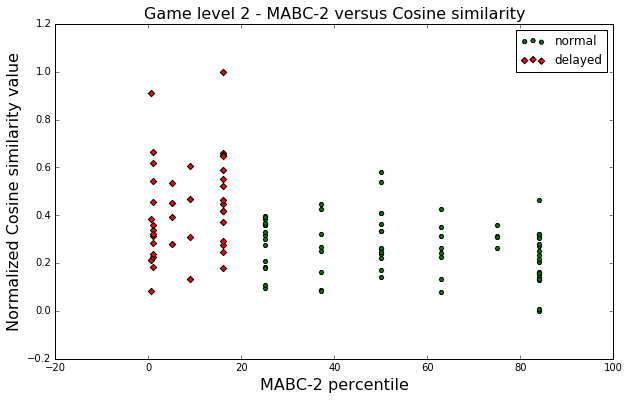

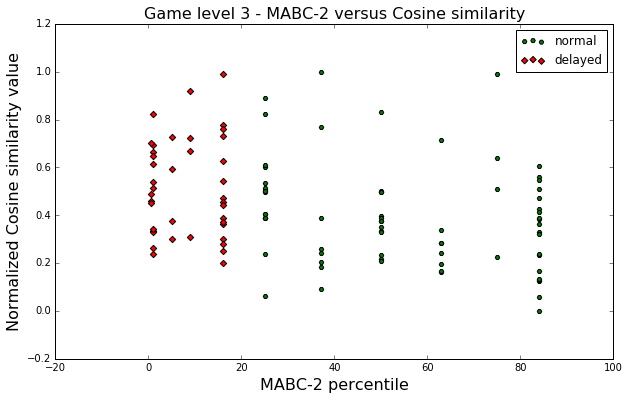

In [5]:

for idx in [2, 5, 6]:

    y_mabc_labels_all = mabc_from_ids(y_label_id, mabc_scores)

    plot_mabc_feature_2D(x_train_all, y_labels_2c, y_mabc_labels_all, idx, "All levels - MABC-2 versus %s" % 
                         feature_long_list[idx])

    for keys, data in level_datasets_2c.iteritems():
        x_data = data[0]
        y_data = data[1]
        y_ids = data[2]
        y_mabc_labels = mabc_from_ids(y_ids, mabc_scores)
        plot_mabc_feature_2D(x_data, y_data, y_mabc_labels, idx, "Game level %d - MABC-2 versus %s" % 
                             (keys, feature_long_list[idx]))